<center> <h1>Thinning</h1> </center>

Simulate non homogeneous Poisson process.

## Required packages

In [162]:
import numpy as np
import math
from numpy.random import normal, uniform, poisson
import matplotlib.pyplot as pl

## Function for baseline

In [163]:
def f_Baseline(a,b,grille):
    lamb0 = np.zeros((grille.shape[0],))
    for k in np.arange(grille.shape[0]):
        lamb0[k] = (b**a)*a*(grille[k]**(a-1))
    return lamb0

## Time Varying Coefficients : $\beta(t)$

In [164]:
def beta_const(grille, param=1.):
    c = param
    beta_const = c*np.ones((grille.shape[0],))
    return beta_const
def beta_piecewise_const(grille, param=(4.,2.,1.)):
    c1,c2,rupture = param
    beta_2_const = c1*(grille<rupture)+c2*(grille>=rupture)
    return beta_2_const
def beta_linear(grille, param=(2.,-0.5)):
    ord_or,pente = param
    beta_lin = ord_or+pente*grille
    return beta_lin
def beta_quadratic(grille, param=(0.5)):
    a = param
    beta_quad = a*grille**2
    return beta_quad

## Time varying covariates : $X(t)$

Chaque X(k) suit une loi normale indépendante

In [165]:
def IndependantNormalX(n, scaleX=0.5):
    X=[]
    n_points = grid.shape[0]
    for i in np.arange(n):#n
        #X_i = np.vstack((i*np.ones(n_points),grid,normal(scale = scaleX, size = (p,n_points)).reshape(((p),n_points)))).T
        X_i = np.vstack((normal(scale = scaleX, size = (p,n_points)).reshape(((p),n_points)))).T
        X.append(X_i)
    return X

## $x_i(t) \beta(t)$

In [166]:
def f_xiBeta(X_i, beta, grid):
    n_i = X_i.shape[0]
    time_length = beta.shape[1]
    Xbeta_i=np.zeros(time_length)
    for t in np.arange(time_length):
        interval = 0
        condition = (grid[t] <= grid[0])
        while condition == False :
            interval += 1
            if interval < n_i:
                condition = (grid[t] <= grid[interval])
        if interval >= n_i:
                interval =n_i-1
                condition = True
        Xbeta_i[t]= np.dot(X_i[interval,:],beta[:,t])
    return Xbeta_i

## $\lambda_i(t) = \lambda_0(t) e^{X(t)\beta(t)}$

In [167]:
def lambda_i(baseline, X_i, beta, grid, nevents=1):
    Xbeta_i = f_xiBeta(X_i, beta, grid)
    lambda_i = nevents * baseline * np.exp(Xbeta_i)
    return lambda_i

In [168]:
## Thinning

In [169]:
def PPH(grid,C):
    t = np.max(grid)
    N_t = poisson(t*C)
    occurence = np.sort(uniform(0,t,N_t))
    return occurence

In [170]:
def thining_timevarying(baseline, X, beta, grid, nevents=1):
    n  = len(X)
    ppnh = []
    accept = []
    for i in np.arange(n):
        intensity_i = lambda_i(baseline, X[i], beta, grid, nevents)
        C = np.max(intensity_i)
        #print "nombre de points moyen", np.max(grid)*C
        Potential_Event = PPH(grid,C)
        N = len(Potential_Event)
        u = uniform(0,1,N)
        # find event intervall
        Potential_Event_Intervall = np.zeros(N)
        Potential_Event_Intensity = np.zeros(N)
        for j in range(N):
            for k in range(len(grid)):
                if grid[k] > Potential_Event[j]:
                    Potential_Event_Intervall[j] = k
                    Potential_Event_Intensity[j] = intensity_i[k]
                    break   
        #intensity_i = lambda_i(baseline, X[i], beta, Potential_Event_Intervall, nevents)
        probas = Potential_Event_Intensity/C
        accept = np.where(u <= probas)#.reshape((N,)))
        if len(accept[0]) == 0:
            # no event = event at t = infinity
            ppnh.append(np.array([math.inf]))
        else:    
            ppnh.append(Potential_Event[accept])
    return ppnh

## Simulations

In [180]:
n = 1000
p = 3
grid = np.linspace(0.1,3,num=50)
baseline = f_Baseline(0.5,1.,grid)
beta = np.vstack([beta_piecewise_const(grid, param=(0.4,0.2,1.)),
                  beta_linear(grid, param=(1.,-0.5)),
                  beta_quadratic(grid, param=(0.15))])
X = IndependantNormalX(n=n, scaleX=0.5)
NHPP = thining_timevarying(baseline, X, beta, grid, nevents=1)

In [181]:
#NHPP

## Format data

In [182]:
s = np.array([])
for j in range(p):
    s = np.append(s,"x"+str(j+1))
data = np.array(["id", "event", "start", "stop"]+list(s))
start = np.array(np.append(0, grid[:-1]))
stop = grid
for i in range(n):
    event_time = NHPP[i][0] # only one event
    for k in range(len(grid)):
        if start[k]<=event_time and event_time<stop[k]:
            data_i_k = np.append([i, 1, start[k], event_time], X[i][k])
            data = np.vstack((data, data_i_k))
            break
        else :
            data_i_k = np.append([i, 0, start[k], stop[k]], X[i][k])
            data = np.vstack((data, data_i_k))

In [183]:
#data

## Write file

In [184]:
nomfichier = "/data/simu.csv"
currentdir = %pwd    
import pandas as pd
df = pd.DataFrame(data) 
print(df.shape)
df.to_csv(currentdir+nomfichier,header=False,index=False)

(19886, 7)


# Debug below

### Event time(s)

In [115]:
NHPP

[array([ 0.36582301,  1.5072888 ,  1.57052687,  1.80551051]),
 array([ 0.34570025,  0.35097941]),
 array([ 1.87055334,  1.92890199]),
 array([ 0.47901336,  0.81408888,  1.20653996,  1.71095638]),
 array([ 1.10111812,  1.94873142]),
 array([ 0.23512697,  0.49804555,  1.09512181,  2.64227343]),
 array([ 0.18356656,  1.34126027,  2.6646854 ,  2.81338452]),
 array([ 0.54094222,  0.87084482,  1.51450814]),
 array([ 1.31536688,  1.43049557,  2.0725546 ,  2.8091816 ]),
 array([ 1.34785438,  2.79835104])]

### Plot baseline

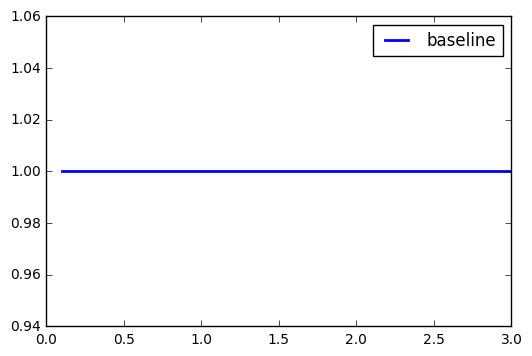

In [116]:
%matplotlib inline
pl.plot(grid, baseline, label="baseline", lw=2)
pl.legend()

### Plot coefficients

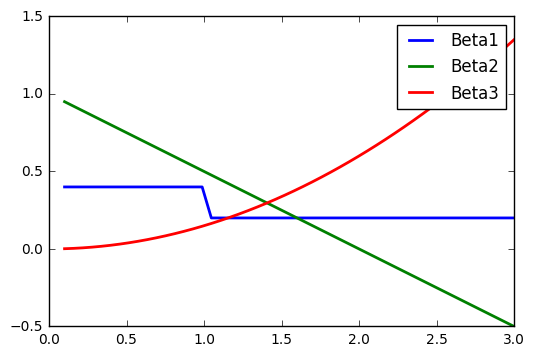

In [117]:
pl.axis([0, 3, -0.5, 1.5])
for j in range(len(beta)) :
    pl.plot(grid, beta[j], label="Beta" + str(j+1), lw=2)
pl.legend()

## Plot $x_i$

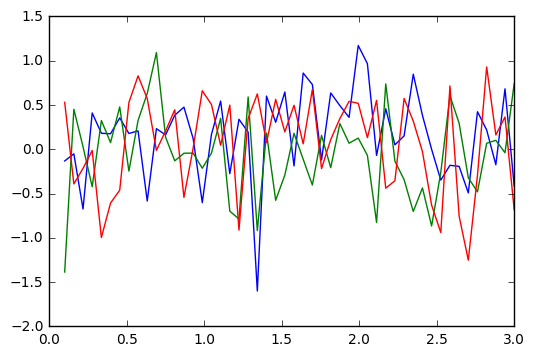

In [118]:
pl.plot(grid,X[0])

### Plot $x_i\beta$

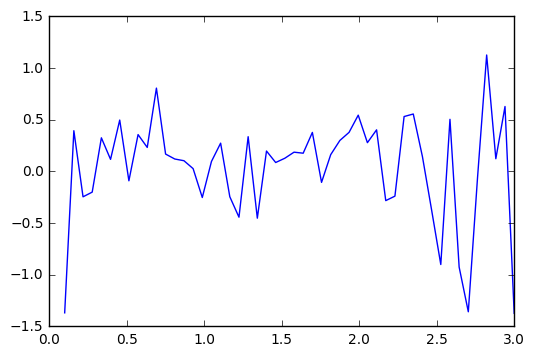

In [119]:
pl.plot(grid, f_xiBeta(X[0], beta, grid))

### Plot $e^{x_i\beta}$

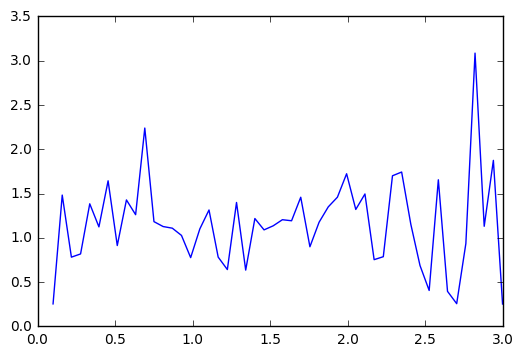

In [120]:
pl.plot(grid, np.exp(f_xiBeta(X[0], beta, grid)))

### plot $\lambda_i(t)$

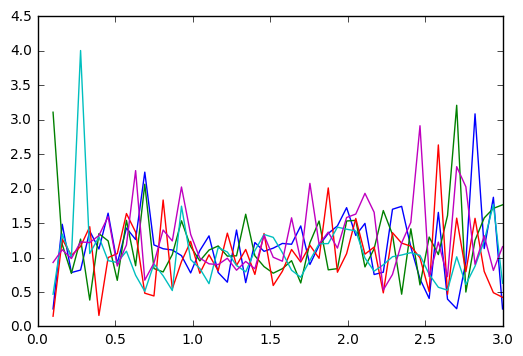

In [121]:
for i in range(min(n,5)):
    pl.plot(grid, lambda_i(baseline, X[i], beta, grid))